In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
pip install mlflow

In [3]:
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Pricing1')

2024/04/22 09:56:22 INFO mlflow.tracking.fluent: Experiment with name 'Pricing1' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/Victoria/gt/MLOp/Housing_Prediction/experiments_tracking/mlruns/2', creation_time=1713779782439, experiment_id='2', last_update_time=1713779782439, lifecycle_stage='active', name='Pricing1', tags={}>

In [4]:
df = pd.read_csv('C:/Users/Victoria/gt/MLOp/Housing_Prediction/Training.csv')

In [7]:
import pandas as pd
def read_dataframe(filename):
    df = pd.read_csv(filename)
    df = df.drop('Id', axis=1)
    df = df.drop(columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

    df = df[df.Neighborhood == 'Avondale']
    df = df[(df.SalePrice >= 100000) & (df.SalePrice <= 500000)]

    categorical = ['BedroomAbvGr', 'GarageCars']
    df[categorical].astype(str)

    return df

# df[categorical].astype(str).dtypes


In [8]:
df_train = read_dataframe('C:/Users/Victoria/gt/MLOp/Housing_Prediction/Training.csv')
df_val = read_dataframe('C:/Users/Victoria/gt/MLOp/Housing_Prediction/Validation.csv')

In [9]:
len(df_train), len(df_val)

(288, 49)

In [10]:
df_train['BedroomAbvGr'] = df_train['BedroomAbvGr'].astype(str)
df_train['GarageCars'] = df_train['GarageCars'].astype(str)

df_train['BED_GAR'] = df_train['BedroomAbvGr'] + '_' + df_train['GarageCars']

df_val['BedroomAbvGr'] = df_val['BedroomAbvGr'].astype(str)
df_val['GarageCars'] = df_val['GarageCars'].astype(str)

df_val['BED_GAR'] = df_val['BedroomAbvGr'] + '_' + df_val['GarageCars']


In [ ]:
df_val

In [12]:
categorical = ['BED_GAR']#'BedroomAbvGr', 'GarageCars']
numerical = ['GarageArea']

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [13]:
target = 'SalePrice'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

36147.195326956426

In [15]:
la = Lasso(alpha=10000000)
la.fit(X_train, y_train)

y_pred = la.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

25833.66489247413

In [16]:
if not os.path.exists('models'):
    os.makedirs('models')

# original code to save the file
with open('models/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, la), f_out)

In [18]:
with mlflow.start_run():

    mlflow.set_tag('Developer', 'Victoria')

    mlflow.log_param('Train', 'C:/Users/Victoria/gt/MLOp/Housing_Prediction/Training.csv')
    mlflow.log_param('Valid', 'C:/Users/Victoria/gt/MLOp/Housing_Prediction/Validation.csv')
    
    alpha=100000000
    
    lr = Ridge(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

In [ ]:
pip install hyperopt

In [20]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [23]:
def objective(params):
      #  params = log and visualize parameters using MLflow
  with mlflow.start_run():
     mlflow.set_tag('model', 'xgboost')
     mlflow.log_params(params)
     booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
     )
     y_pred = booster.predict(valid)
     rmse = mean_squared_error(y_val, y_pred, squared=False)
     mlflow.log_metric('rmse', rmse)

  return {'loss': rmse, 'status': STATUS_OK}

In [24]:
 search_space = {
     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
     'learning_rate': hp.loguniform('learning_rate', -3, 0),
     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
     'reg_lambda': hp.loguniform('reg_lamba', -6, -1),
     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
     'objective': 'reg:linear',
     'seed': 42,
 }

 best_result = fmin(
     fn=objective,
     space=search_space,
     algo=tpe.suggest,
     max_evals=50,
     trials=Trials())

[0]	validation-rmse:27238.26067                       
[1]	validation-rmse:28782.30680                       
[2]	validation-rmse:30277.36804                       
[3]	validation-rmse:31910.41623                       
[4]	validation-rmse:33299.82752                       
[5]	validation-rmse:34313.29169                       
[6]	validation-rmse:35319.02029                       
[7]	validation-rmse:35944.93450                       
[8]	validation-rmse:36816.67591                       
[9]	validation-rmse:37287.18793                       
[10]	validation-rmse:38066.48975                      
[11]	validation-rmse:38357.64534                      
[12]	validation-rmse:38659.50477                      
[13]	validation-rmse:38868.78913                      
[14]	validation-rmse:39074.96110                      
[15]	validation-rmse:39093.31879                      
[16]	validation-rmse:39473.74323                      
[17]	validation-rmse:39532.85859                      
[18]	valid

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:40234.70208
[24]	validation-rmse:40220.60165                      
[25]	validation-rmse:40311.23302                      
[26]	validation-rmse:40376.61062                      
[27]	validation-rmse:40394.06417                      
[28]	validation-rmse:40271.80695                      
[29]	validation-rmse:40353.44448                      
[30]	validation-rmse:40392.57720                      
[31]	validation-rmse:40292.09876                      
[32]	validation-rmse:40274.65301                      
[33]	validation-rmse:40298.40670                      
[34]	validation-rmse:40311.04694                      
[35]	validation-rmse:40276.64513                      
[36]	validation-rmse:40274.90364                      
[37]	validation-rmse:40193.37772                      
[38]	validation-rmse:40014.78861                      
[39]	validation-rmse:40078.74116                      
[40]	validation-rmse:40248.09644                      
[41]	validation-rmse:40215.08679

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:48749.53557
[31]	validation-rmse:48814.60292                                                
[32]	validation-rmse:48810.32315                                                
[33]	validation-rmse:49000.34755                                                
[34]	validation-rmse:49029.14774                                                
[35]	validation-rmse:48854.71140                                                
[36]	validation-rmse:49105.16781                                                
[37]	validation-rmse:49122.78749                                                
[38]	validation-rmse:49067.26000                                                
[39]	validation-rmse:49217.42858                                                
[40]	validation-rmse:49172.84781                                                
[41]	validation-rmse:49187.49658                                                
[42]	validation-rmse:49113.93712                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:46350.16153                                                
[31]	validation-rmse:46350.16018                                                
[32]	validation-rmse:46350.15996                                                
[33]	validation-rmse:46350.15973                                                
[34]	validation-rmse:46350.15951                                                
[35]	validation-rmse:46350.15928                                                
[36]	validation-rmse:46350.15905                                                
[37]	validation-rmse:46350.15883                                                
[38]	validation-rmse:46350.15860                                                
[39]	validation-rmse:46350.15838                                                
[40]	validation-rmse:46350.15815                                                
[41]	validation-rmse:46350.15793                                                
[42]	validation-rmse:46350.1

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:46589.90264                                                
[29]	validation-rmse:46761.50735                                                
[30]	validation-rmse:46918.64427                                                
[31]	validation-rmse:47062.51757                                                
[32]	validation-rmse:47194.23829                                                
[33]	validation-rmse:47314.81998                                                
[34]	validation-rmse:47425.19785                                                
[35]	validation-rmse:47526.22944                                                
[36]	validation-rmse:47618.69950                                                
[37]	validation-rmse:47703.32948                                                
[38]	validation-rmse:47780.77889                                                
[39]	validation-rmse:47851.65646                                                
[40]	validation-rmse:47916.5

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:41092.16212                                                
[26]	validation-rmse:41137.85699                                                
[27]	validation-rmse:41237.25044                                                
[28]	validation-rmse:41250.50009                                                
[29]	validation-rmse:41438.02827                                                
[30]	validation-rmse:41435.46805                                                
[31]	validation-rmse:41446.29747                                                
[32]	validation-rmse:41456.82644                                                
[33]	validation-rmse:41657.88945                                                
[34]	validation-rmse:41588.74133                                                
[35]	validation-rmse:41480.48202                                                
[36]	validation-rmse:41591.74330                                                
[37]	validation-rmse:41619.0

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:46834.75368                                                
[22]	validation-rmse:46934.49482                                                
[23]	validation-rmse:47016.12666                                                
[24]	validation-rmse:47081.00526                                                
[25]	validation-rmse:47139.01814                                                
[26]	validation-rmse:47188.54210                                                
[27]	validation-rmse:47235.35242                                                
[28]	validation-rmse:47271.33763                                                
[29]	validation-rmse:47300.55589                                                
[30]	validation-rmse:47325.48329                                                
[31]	validation-rmse:47349.02519                                                
[32]	validation-rmse:47367.22611                                                
[33]	validation-rmse:47383.0

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:39421.79030                                                
[34]	validation-rmse:39487.87146                                                
[35]	validation-rmse:39447.35289                                                
[36]	validation-rmse:39515.40980                                                
[37]	validation-rmse:39435.54831                                                
[38]	validation-rmse:39454.79262                                                
[39]	validation-rmse:39575.39174                                                
[40]	validation-rmse:39580.58879                                                
[41]	validation-rmse:39506.79908                                                
[42]	validation-rmse:39534.32917                                                
[43]	validation-rmse:39513.04406                                                
[44]	validation-rmse:39487.68321                                                
[45]	validation-rmse:39420.9

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:46959.75246
[34]	validation-rmse:46966.13877                                               
[35]	validation-rmse:46972.17170                                               
[36]	validation-rmse:46976.98788                                               
[37]	validation-rmse:46981.21164                                               
[38]	validation-rmse:46984.86840                                               
[39]	validation-rmse:46987.63826                                               
[40]	validation-rmse:46990.08975                                               
[41]	validation-rmse:46992.02792                                               
[42]	validation-rmse:46993.58870                                               
[43]	validation-rmse:46994.83105                                               
[44]	validation-rmse:46995.90478                                               
[45]	validation-rmse:46996.79921                                               
[46]	va

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:38994.34016                                               
[24]	validation-rmse:39310.37734                                               
[25]	validation-rmse:39611.55924                                               
[26]	validation-rmse:39899.38394                                               
[27]	validation-rmse:40192.00299                                               
[28]	validation-rmse:40457.84005                                               
[29]	validation-rmse:40691.78848                                               
[30]	validation-rmse:40908.72470                                               
[31]	validation-rmse:41157.82861                                               
[32]	validation-rmse:41370.37250                                               
[33]	validation-rmse:41584.44902                                               
[34]	validation-rmse:41703.08846                                               
[35]	validation-rmse:41825.33545        

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:48483.40796                                               
[35]	validation-rmse:48498.22802                                               
[36]	validation-rmse:48504.10741                                               
[37]	validation-rmse:48499.02738                                               
[38]	validation-rmse:48519.52441                                               
[39]	validation-rmse:48526.79557                                               
[40]	validation-rmse:48523.43778                                               
[41]	validation-rmse:48522.63684                                               
[42]	validation-rmse:48537.04634                                               
[43]	validation-rmse:48542.95084                                               
[44]	validation-rmse:48538.11294                                               
[45]	validation-rmse:48526.06257                                               
[46]	validation-rmse:48547.19330        

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:42534.91474                                                
[31]	validation-rmse:43083.30767                                                
[32]	validation-rmse:43204.57018                                                
[33]	validation-rmse:43837.14582                                                
[34]	validation-rmse:44405.14609                                                
[35]	validation-rmse:44532.54313                                                
[36]	validation-rmse:44986.57971                                                
[37]	validation-rmse:44915.14312                                                
[38]	validation-rmse:45115.80410                                                
[39]	validation-rmse:45120.05978                                                
[40]	validation-rmse:45264.30692                                                
[41]	validation-rmse:45375.69680                                                
[42]	validation-rmse:45543.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[32]	validation-rmse:46277.00614                                                
[33]	validation-rmse:46292.63642                                                
[34]	validation-rmse:46305.03964                                                
[35]	validation-rmse:46370.14513                                                
[36]	validation-rmse:46381.22033                                                
[37]	validation-rmse:46376.59108                                                
[38]	validation-rmse:46406.78290                                                
[39]	validation-rmse:46436.10510                                                
[40]	validation-rmse:46411.05017                                                
[41]	validation-rmse:46419.10716                                                
[42]	validation-rmse:46451.98446                                                
[43]	validation-rmse:46463.67023                                                
[44]	validation-rmse:46453.9

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:45531.73804                                                
[24]	validation-rmse:45716.33576                                                
[25]	validation-rmse:45760.90028                                                
[26]	validation-rmse:45602.51955                                                
[27]	validation-rmse:45830.18673                                                
[28]	validation-rmse:46216.86415                                                
[29]	validation-rmse:46022.49491                                                
[30]	validation-rmse:45984.52459                                                
[31]	validation-rmse:46407.83201                                                
[32]	validation-rmse:46338.97985                                                
[33]	validation-rmse:46710.53168                                                
[34]	validation-rmse:47225.66621                                                
[35]	validation-rmse:46802.6

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:46587.99323
[26]	validation-rmse:46575.77621                                                
[27]	validation-rmse:46607.79733                                                
[28]	validation-rmse:46577.50716                                                
[29]	validation-rmse:46519.03621                                                
[30]	validation-rmse:46598.61482                                                
[31]	validation-rmse:46571.94318                                                
[32]	validation-rmse:46612.91812                                                
[33]	validation-rmse:46559.52113                                                
[34]	validation-rmse:46613.32809                                                
[35]	validation-rmse:46601.67724                                                
[36]	validation-rmse:46638.60883                                                
[37]	validation-rmse:46688.23273                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:42659.97393                                                
[37]	validation-rmse:42516.80904                                                
[38]	validation-rmse:42209.34246                                                
[39]	validation-rmse:42559.78057                                                
[40]	validation-rmse:42608.27356                                                
[41]	validation-rmse:42689.38658                                                
[42]	validation-rmse:42508.09894                                                
[43]	validation-rmse:42342.78268                                                
[44]	validation-rmse:42581.07680                                                
[45]	validation-rmse:42591.33035                                                
[46]	validation-rmse:42999.56165                                                
[47]	validation-rmse:42695.87423                                                
[48]	validation-rmse:42938.6

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[15]	validation-rmse:45108.04318                                                
[16]	validation-rmse:44876.73393                                                
[17]	validation-rmse:44795.09779                                                
[18]	validation-rmse:44967.94083                                                
[19]	validation-rmse:45094.23940                                                
[20]	validation-rmse:45127.07017                                                
[21]	validation-rmse:45288.59073                                                
[22]	validation-rmse:45273.80150                                                
[23]	validation-rmse:45174.37844                                                
[24]	validation-rmse:44947.90045                                                
[25]	validation-rmse:45075.88803                                                
[26]	validation-rmse:45106.67387                                                
[27]	validation-rmse:45212.7

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:45056.72569                                                
[28]	validation-rmse:45040.55873                                                
[29]	validation-rmse:45159.61289                                                
[30]	validation-rmse:45249.56131                                                
[31]	validation-rmse:45360.52417                                                
[32]	validation-rmse:45401.27284                                                
[33]	validation-rmse:45381.27860                                                
[34]	validation-rmse:45439.69931                                                
[35]	validation-rmse:45487.74006                                                
[36]	validation-rmse:45533.67738                                                
[37]	validation-rmse:45487.95918                                                
[38]	validation-rmse:45628.06507                                                
[39]	validation-rmse:45633.4

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[32]	validation-rmse:47153.05532                                                
[33]	validation-rmse:47444.82260                                                
[34]	validation-rmse:47559.32902                                                
[35]	validation-rmse:47694.74654                                                
[36]	validation-rmse:47692.28667                                                
[37]	validation-rmse:47943.74648                                                
[38]	validation-rmse:48009.31082                                                
[39]	validation-rmse:48046.81003                                                
[40]	validation-rmse:48056.49340                                                
[41]	validation-rmse:48012.45906                                                
[42]	validation-rmse:48083.94372                                                
[43]	validation-rmse:48079.88462                                                
[44]	validation-rmse:48136.1

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:48343.74059                                                
[19]	validation-rmse:48354.01648                                                
[20]	validation-rmse:48361.32058                                                
[21]	validation-rmse:48366.50806                                                
[22]	validation-rmse:48370.21736                                                
[23]	validation-rmse:48373.00246                                                
[24]	validation-rmse:48375.10424                                                
[25]	validation-rmse:48376.47709                                                
[26]	validation-rmse:48377.37283                                                
[27]	validation-rmse:48378.04257                                                
[28]	validation-rmse:48378.49012                                                
[29]	validation-rmse:48378.80635                                                
[30]	validation-rmse:48379.0

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:40635.35441                                                
[31]	validation-rmse:40756.17785                                                
[32]	validation-rmse:40821.17899                                                
[33]	validation-rmse:40821.04659                                                
[34]	validation-rmse:40699.48434                                                
[35]	validation-rmse:40748.18542                                                
[36]	validation-rmse:40671.39180                                                
[37]	validation-rmse:40821.47022                                                
[38]	validation-rmse:40787.40890                                                
[39]	validation-rmse:40745.82987                                                
[40]	validation-rmse:40609.81364                                                
[41]	validation-rmse:40643.47826                                                
[42]	validation-rmse:40657.9

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[37]	validation-rmse:40906.07001                                                
[38]	validation-rmse:40998.80830                                                
[39]	validation-rmse:41004.00323                                                
[40]	validation-rmse:40974.17041                                                
[41]	validation-rmse:40930.00251                                                
[42]	validation-rmse:40905.79770                                                
[43]	validation-rmse:40936.73172                                                
[44]	validation-rmse:40929.43485                                                
[45]	validation-rmse:40988.12754                                                
[46]	validation-rmse:40926.87930                                                
[47]	validation-rmse:40933.63400                                                
[48]	validation-rmse:40943.32013                                                
[49]	validation-rmse:40923.9

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[39]	validation-rmse:42068.89695                                                
[40]	validation-rmse:42039.52711                                                
[41]	validation-rmse:42087.87323                                                
[42]	validation-rmse:42066.47906                                                
[43]	validation-rmse:42092.12263                                                
[44]	validation-rmse:42074.09440                                                
[45]	validation-rmse:42111.14295                                                
[46]	validation-rmse:42156.58422                                                
[47]	validation-rmse:42194.88847                                                
[48]	validation-rmse:42185.20575                                                
[49]	validation-rmse:42199.15027                                                
[50]	validation-rmse:42283.02385                                                
[0]	validation-rmse:26739.09

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[24]	validation-rmse:38906.00778
[25]	validation-rmse:38910.18721                                                
[26]	validation-rmse:38889.14065                                                
[27]	validation-rmse:38901.64244                                                
[28]	validation-rmse:38910.12141                                                
[29]	validation-rmse:38837.08052                                                
[30]	validation-rmse:39000.12499                                                
[31]	validation-rmse:39020.29783                                                
[32]	validation-rmse:39198.75453                                                
[33]	validation-rmse:39206.73105                                                
[34]	validation-rmse:39223.74673                                                
[35]	validation-rmse:39264.89863                                                
[36]	validation-rmse:39286.22542                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[17]	validation-rmse:36189.84153                                                
[18]	validation-rmse:36539.44799                                                
[19]	validation-rmse:36673.41855                                                
[20]	validation-rmse:36989.21072                                                
[21]	validation-rmse:37377.71912                                                
[22]	validation-rmse:37558.56420                                                
[23]	validation-rmse:37840.62730                                                
[24]	validation-rmse:37938.64122                                                
[25]	validation-rmse:38242.29423                                                
[26]	validation-rmse:38470.23209                                                
[27]	validation-rmse:38773.16990                                                
[28]	validation-rmse:38869.89254                                                
[29]	validation-rmse:39067.7

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:39056.30801                                                
[30]	validation-rmse:39282.18722                                                
[31]	validation-rmse:39330.05873                                                
[32]	validation-rmse:39409.86928                                                
[33]	validation-rmse:39463.08036                                                
[34]	validation-rmse:39729.94422                                                
[35]	validation-rmse:39842.35181                                                
[36]	validation-rmse:40033.05003                                                
[37]	validation-rmse:40144.85563                                                
[38]	validation-rmse:40287.68772                                                
[39]	validation-rmse:40508.97627                                                
[40]	validation-rmse:40639.60328                                                
[41]	validation-rmse:40663.5

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:38576.27349                                                
[35]	validation-rmse:38710.49942                                                
[36]	validation-rmse:38724.75486                                                
[37]	validation-rmse:38731.02675                                                
[38]	validation-rmse:38470.40353                                                
[39]	validation-rmse:38586.01836                                                
[40]	validation-rmse:38600.82298                                                
[41]	validation-rmse:38589.02468                                                
[42]	validation-rmse:38717.46242                                                
[43]	validation-rmse:38717.86763                                                
[44]	validation-rmse:38712.55688                                                
[45]	validation-rmse:38703.21058                                                
[46]	validation-rmse:38769.9

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:37647.67606
[26]	validation-rmse:37967.25853                                                
[27]	validation-rmse:38279.74587                                                
[28]	validation-rmse:38575.97189                                                
[29]	validation-rmse:38690.25109                                                
[30]	validation-rmse:38954.12430                                                
[31]	validation-rmse:39234.60997                                                
[32]	validation-rmse:39307.83168                                                
[33]	validation-rmse:39540.55180                                                
[34]	validation-rmse:39745.23971                                                
[35]	validation-rmse:39941.58491                                                
[36]	validation-rmse:39959.01377                                                
[37]	validation-rmse:40109.18779                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:37858.94831
[37]	validation-rmse:37922.94125                                                
[38]	validation-rmse:37938.22689                                                
[39]	validation-rmse:38050.34997                                                
[40]	validation-rmse:37917.99756                                                
[41]	validation-rmse:37961.80438                                                
[42]	validation-rmse:38037.19228                                                
[43]	validation-rmse:38102.07085                                                
[44]	validation-rmse:37988.56444                                                
[45]	validation-rmse:38113.12008                                                
[46]	validation-rmse:38116.93226                                                
[47]	validation-rmse:38077.78237                                                
[48]	validation-rmse:38162.70454                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:35647.85984
[22]	validation-rmse:36017.33382                                                
[23]	validation-rmse:36358.19461                                                
[24]	validation-rmse:36526.10725                                                
[25]	validation-rmse:36814.77631                                                
[26]	validation-rmse:36952.31727                                                
[27]	validation-rmse:37206.74742                                                
[28]	validation-rmse:37342.65793                                                
[29]	validation-rmse:37446.08937                                                
[30]	validation-rmse:37523.08049                                                
[31]	validation-rmse:37600.92775                                                
[32]	validation-rmse:37671.79275                                                
[33]	validation-rmse:37886.11038                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)




[23]	validation-rmse:37355.52922                                                
[24]	validation-rmse:37525.17501                                                
[25]	validation-rmse:37735.95688                                                
[26]	validation-rmse:37965.29866                                                
[27]	validation-rmse:38089.96408                                                
[28]	validation-rmse:38315.26356                                                
[29]	validation-rmse:38441.82577                                                
[30]	validation-rmse:38465.28979                                                
[31]	validation-rmse:38568.23633                                                
[32]	validation-rmse:38600.00507                                                
[33]	validation-rmse:38718.86083                                                
[34]	validation-rmse:38782.30442                                                
[35]	validation-rmse:38806.

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:38656.44358                                                
[34]	validation-rmse:38791.10856                                                
[35]	validation-rmse:38844.20701                                                
[36]	validation-rmse:38903.43051                                                
[37]	validation-rmse:39108.44785                                                
[38]	validation-rmse:39306.29753                                                
[39]	validation-rmse:39384.14269                                                
[40]	validation-rmse:39568.15712                                                
[41]	validation-rmse:39735.89123                                                
[42]	validation-rmse:39853.53954                                                
[43]	validation-rmse:39923.60873                                                
[44]	validation-rmse:39983.86967                                                
[45]	validation-rmse:39987.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[17]	validation-rmse:33593.09887                                                
[18]	validation-rmse:33859.11138                                                
[19]	validation-rmse:34220.32177                                                
[20]	validation-rmse:34564.68633                                                
[21]	validation-rmse:34930.85718                                                
[22]	validation-rmse:35284.16307                                                
[23]	validation-rmse:35596.16440                                                
[24]	validation-rmse:35911.03944                                                
[25]	validation-rmse:36012.86105                                                
[26]	validation-rmse:36305.39465                                                
[27]	validation-rmse:36583.28323                                                
[28]	validation-rmse:36854.36352                                                
[29]	validation-rmse:37102.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:41358.16095                                                
[24]	validation-rmse:41649.64916                                                
[25]	validation-rmse:41923.24524                                                
[26]	validation-rmse:42113.90202                                                
[27]	validation-rmse:42271.80117                                                
[28]	validation-rmse:42448.03706                                                
[29]	validation-rmse:42680.51922                                                
[30]	validation-rmse:42944.92347                                                
[31]	validation-rmse:43088.67203                                                
[32]	validation-rmse:43168.72632                                                
[33]	validation-rmse:43442.16525                                                
[34]	validation-rmse:43546.02497                                                
[35]	validation-rmse:43643.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:41155.11373                                                
[35]	validation-rmse:41144.56252                                                
[36]	validation-rmse:41331.05967                                                
[37]	validation-rmse:41391.70912                                                
[38]	validation-rmse:41428.87587                                                
[39]	validation-rmse:41444.82905                                                
[40]	validation-rmse:41404.20575                                                
[41]	validation-rmse:41410.69585                                                
[42]	validation-rmse:41456.86971                                                
[43]	validation-rmse:41491.44238                                                
[44]	validation-rmse:41496.63992                                                
[45]	validation-rmse:41471.99180                                                
[46]	validation-rmse:41571.2

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:44176.37252                                                
[20]	validation-rmse:44621.18089                                                
[21]	validation-rmse:44808.68831                                                
[22]	validation-rmse:45147.91870                                                
[23]	validation-rmse:45055.08443                                                
[24]	validation-rmse:45317.35573                                                
[25]	validation-rmse:45425.24310                                                
[26]	validation-rmse:45598.21806                                                
[27]	validation-rmse:45805.04988                                                
[28]	validation-rmse:45789.75654                                                
[29]	validation-rmse:46012.02839                                                
[30]	validation-rmse:46021.65425                                                
[31]	validation-rmse:46029.0

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:37214.94759                                                
[30]	validation-rmse:37384.41506                                                
[31]	validation-rmse:37547.52824                                                
[32]	validation-rmse:37607.51199                                                
[33]	validation-rmse:37697.54515                                                
[34]	validation-rmse:37869.07045                                                
[35]	validation-rmse:37945.24918                                                
[36]	validation-rmse:37996.63601                                                
[37]	validation-rmse:38073.53919                                                
[38]	validation-rmse:38340.43629                                                
[39]	validation-rmse:38594.94432                                                
[40]	validation-rmse:38618.34694                                                
[41]	validation-rmse:38641.8

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:47782.03361                                                
[29]	validation-rmse:47788.81736                                                
[30]	validation-rmse:47794.43477                                                
[31]	validation-rmse:47798.81239                                                
[32]	validation-rmse:47802.96351                                                
[33]	validation-rmse:47806.07757                                                
[34]	validation-rmse:47808.63304                                                
[35]	validation-rmse:47810.85687                                                
[36]	validation-rmse:47812.89619                                                
[37]	validation-rmse:47814.69157                                                
[38]	validation-rmse:47816.08962                                                
[39]	validation-rmse:47817.25394                                                
[40]	validation-rmse:47818.0

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:42104.32779
[23]	validation-rmse:42198.54475                                                
[24]	validation-rmse:42275.90103                                                
[25]	validation-rmse:42338.19590                                                
[26]	validation-rmse:42403.59092                                                
[27]	validation-rmse:42466.30903                                                
[28]	validation-rmse:42542.23068                                                
[29]	validation-rmse:42571.63570                                                
[30]	validation-rmse:42570.22272                                                
[31]	validation-rmse:42643.72105                                                
[32]	validation-rmse:42654.30510                                                
[33]	validation-rmse:42718.68780                                                
[34]	validation-rmse:42791.82356                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:36810.02769                                                
[23]	validation-rmse:37139.32162                                                
[24]	validation-rmse:37443.76852                                                
[25]	validation-rmse:37567.30270                                                
[26]	validation-rmse:37861.15573                                                
[27]	validation-rmse:38130.88630                                                
[28]	validation-rmse:38381.14962                                                
[29]	validation-rmse:38553.93773                                                
[30]	validation-rmse:38818.69352                                                
[31]	validation-rmse:39051.97569                                                
[32]	validation-rmse:39278.48876                                                
[33]	validation-rmse:39490.42674                                                
[34]	validation-rmse:39489.4

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:39924.57877                                                
[31]	validation-rmse:39957.91322                                                
[32]	validation-rmse:40026.30104                                                
[33]	validation-rmse:40007.41019                                                
[34]	validation-rmse:39935.12664                                                
[35]	validation-rmse:39953.30141                                                
[36]	validation-rmse:39982.44893                                                
[37]	validation-rmse:40037.43665                                                
[38]	validation-rmse:40062.66225                                                
[39]	validation-rmse:40021.30887                                                
[40]	validation-rmse:40042.12053                                                
[41]	validation-rmse:40176.26760                                                
[42]	validation-rmse:40189.8

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:44840.49233                                                
[23]	validation-rmse:44947.32222                                                
[24]	validation-rmse:45021.53509                                                
[25]	validation-rmse:45058.42721                                                
[26]	validation-rmse:45049.97393                                                
[27]	validation-rmse:45111.53443                                                
[28]	validation-rmse:45158.43763                                                
[29]	validation-rmse:45171.28576                                                
[30]	validation-rmse:45173.44039                                                
[31]	validation-rmse:45212.89987                                                
[32]	validation-rmse:45226.84634                                                
[33]	validation-rmse:45223.27708                                                
[34]	validation-rmse:45286.5

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:38650.09995                                                
[22]	validation-rmse:39026.55168                                                
[23]	validation-rmse:39327.09951                                                
[24]	validation-rmse:39682.91910                                                
[25]	validation-rmse:40006.26114                                                
[26]	validation-rmse:40332.38293                                                
[27]	validation-rmse:40598.76216                                                
[28]	validation-rmse:40895.11821                                                
[29]	validation-rmse:41107.69437                                                
[30]	validation-rmse:41348.09615                                                
[31]	validation-rmse:41578.04550                                                
[32]	validation-rmse:41847.90865                                                
[33]	validation-rmse:42050.7

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:41856.63844
[30]	validation-rmse:41912.15627                                                
[31]	validation-rmse:41914.20024                                                
[32]	validation-rmse:41876.69778                                                
[33]	validation-rmse:41991.82018                                                
[34]	validation-rmse:41933.59592                                                
[35]	validation-rmse:41999.38034                                                
[36]	validation-rmse:42034.59144                                                
[37]	validation-rmse:42065.86188                                                
[38]	validation-rmse:42167.53153                                                
[39]	validation-rmse:42137.10857                                                
[40]	validation-rmse:42105.15513                                                
[41]	validation-rmse:42205.85791                                            

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[26]	validation-rmse:37003.50169                                                
[27]	validation-rmse:37163.73379                                                
[28]	validation-rmse:37399.47704                                                
[29]	validation-rmse:37541.49838                                                
[30]	validation-rmse:37711.25620                                                
[31]	validation-rmse:37957.74919                                                
[32]	validation-rmse:38143.07240                                                
[33]	validation-rmse:38250.63427                                                
[34]	validation-rmse:38438.26199                                                
[35]	validation-rmse:38574.47948                                                
[36]	validation-rmse:38716.41132                                                
[37]	validation-rmse:38858.46089                                                
[38]	validation-rmse:38957.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[16]	validation-rmse:38256.10573                                                
[17]	validation-rmse:38578.11181                                                
[18]	validation-rmse:38980.39767                                                
[19]	validation-rmse:39256.74846                                                
[20]	validation-rmse:39529.97106                                                
[21]	validation-rmse:39691.88217                                                
[22]	validation-rmse:39807.15168                                                
[23]	validation-rmse:39897.01663                                                
[24]	validation-rmse:40044.79649                                                
[25]	validation-rmse:40154.41693                                                
[26]	validation-rmse:40247.09372                                                
[27]	validation-rmse:40429.68558                                                
[28]	validation-rmse:40518.5

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[24]	validation-rmse:39432.06612                                                
[25]	validation-rmse:39437.07943                                                
[26]	validation-rmse:39357.51440                                                
[27]	validation-rmse:39404.68710                                                
[28]	validation-rmse:39301.89027                                                
[29]	validation-rmse:39348.91325                                                
[30]	validation-rmse:39288.11266                                                
[31]	validation-rmse:39355.44961                                                
[32]	validation-rmse:39270.94888                                                
[33]	validation-rmse:39262.23201                                                
[34]	validation-rmse:39304.91358                                                
[35]	validation-rmse:39324.84270                                                
[36]	validation-rmse:39230.0

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:44185.33603                                                
[24]	validation-rmse:44251.53393                                                
[25]	validation-rmse:44277.54670                                                
[26]	validation-rmse:44350.84954                                                
[27]	validation-rmse:44376.80663                                                
[28]	validation-rmse:44400.58487                                                
[29]	validation-rmse:44316.49536                                                
[30]	validation-rmse:44432.76096                                                
[31]	validation-rmse:44409.06061                                                
[32]	validation-rmse:44450.98778                                                
[33]	validation-rmse:44499.12181                                                
[34]	validation-rmse:44564.28120                                                
[35]	validation-rmse:44600.1

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:41080.31246                                                
[32]	validation-rmse:41176.65342                                                
[33]	validation-rmse:41322.54048                                                
[34]	validation-rmse:41351.90002                                                
[35]	validation-rmse:41542.50738                                                
[36]	validation-rmse:41680.42793                                                
[37]	validation-rmse:41676.13091                                                
[38]	validation-rmse:41720.29480                                                
[39]	validation-rmse:41694.26595                                                
[40]	validation-rmse:41741.58231                                                
[41]	validation-rmse:41839.01434                                                
[42]	validation-rmse:41875.23436                                                
[43]	validation-rmse:41871.5

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:43781.81975                                                
[22]	validation-rmse:44060.84932                                                
[23]	validation-rmse:44318.93509                                                
[24]	validation-rmse:44549.65405                                                
[25]	validation-rmse:44734.93006                                                
[26]	validation-rmse:44868.22198                                                
[27]	validation-rmse:45036.70908                                                
[28]	validation-rmse:45187.93237                                                
[29]	validation-rmse:45306.36865                                                
[30]	validation-rmse:45431.55833                                                
[31]	validation-rmse:45539.22167                                                
[32]	validation-rmse:45637.15631                                                
[33]	validation-rmse:45730.4

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:49052.75096                                                
[32]	validation-rmse:49215.08287                                                
[33]	validation-rmse:49354.43451                                                
[34]	validation-rmse:49364.79696                                                
[35]	validation-rmse:49465.88808                                                
[36]	validation-rmse:49462.29386                                                
[37]	validation-rmse:49560.15914                                                
[38]	validation-rmse:49566.71408                                                
[39]	validation-rmse:49668.91074                                                
[40]	validation-rmse:49721.04430                                                
[41]	validation-rmse:49719.34114                                                
[42]	validation-rmse:49735.47103                                                
[43]	validation-rmse:49756.0

In [29]:
params = {
    'learning_rate': 0.06285818871453905,
     'max_depth': 78,
    'min_child_weight': 16.997027875383516,
    'objective': 'reg:linear',
    'reg_alpha': 0.012917821011080867,
    'reg_lambda': 0.006580801272479912,
    'seed': 42
}
mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/04/15 11:35:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '94a598094ffd40f39af9d6d25f3af0ed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:26335.08006
[1]	validation-rmse:26814.86308
[2]	validation-rmse:27377.35945
[3]	validation-rmse:27969.49536
[4]	validation-rmse:28480.58092


c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[5]	validation-rmse:29097.80046
[6]	validation-rmse:29595.35445
[7]	validation-rmse:30225.90529
[8]	validation-rmse:30850.75593
[9]	validation-rmse:31411.03529
[10]	validation-rmse:31822.83228
[11]	validation-rmse:32351.88460
[12]	validation-rmse:32813.08306
[13]	validation-rmse:33146.61784
[14]	validation-rmse:33522.85395
[15]	validation-rmse:33882.71559
[16]	validation-rmse:34302.51793
[17]	validation-rmse:34659.31893
[18]	validation-rmse:34952.97828
[19]	validation-rmse:35225.89559
[20]	validation-rmse:35478.25532
[21]	validation-rmse:35767.12901
[22]	validation-rmse:36099.44817
[23]	validation-rmse:36314.94878
[24]	validation-rmse:36502.20798
[25]	validation-rmse:36700.61385
[26]	validation-rmse:37030.60940
[27]	validation-rmse:37342.91150
[28]	validation-rmse:37500.92980
[29]	validation-rmse:37512.28507
[30]	validation-rmse:37648.55076
[31]	validation-rmse:37658.42490
[32]	validation-rmse:37790.20149
[33]	validation-rmse:37921.23800
[34]	validation-rmse:38062.17895
[35]	validation

2024/04/15 11:35:04 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/04/15 11:35:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


C:\Users\2024\AppData\Local\Temp\ipykernel_1344\1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\2024\AppData\Local\Temp\ipykernel_1344\1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


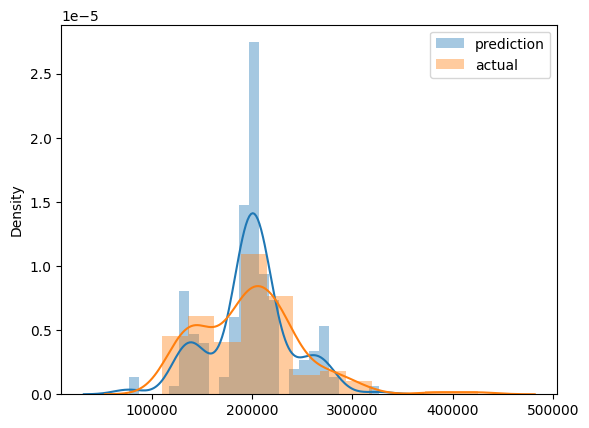

In [113]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

c:\Users\2024\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


31648.219425044535